In [37]:
import os
import tqdm
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# 设置绘图风格
plt.rcParams["font.sans-serif"] = ["SimHei"]
matplotlib.rcParams["axes.unicode_minus"] = False
five_mins_data = pd.read_table(
    "./HSI_5分钟线.txt", encoding="gb18030", skiprows=1, dtype=str
)
five_mins_data = five_mins_data.iloc[:-1]
five_mins_data.columns = five_mins_data.columns.str.strip()
five_mins_data["收盘"] = five_mins_data["收盘"].astype(float)
five_mins_data["日期时间"] = five_mins_data["日期"] + " " + five_mins_data["时间"]
five_mins_data["日期时间"] = pd.to_datetime(five_mins_data["日期时间"])
five_mins_data


def calculate_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    average_gain = up.rolling(window=window).mean()
    average_loss = abs(down.rolling(window=window).mean())

    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


rsi = calculate_rsi(five_mins_data["收盘"], 14)

close = five_mins_data["收盘"]

# 计算 RSV
low_list = pd.Series.rolling(close, window=9).min()
high_list = pd.Series.rolling(close, window=9).max()
rsv = (close - low_list) / (high_list - low_list) * 100

# 计算 KDJ
K = pd.Series.ewm(rsv, adjust=False, alpha=1 / 3).mean()
D = pd.Series.ewm(K, adjust=False, alpha=1 / 3).mean()
J = 3 * K - 2 * D

# 将 KDJ 添加到 series_df
five_mins_data["K"] = K
five_mins_data["D"] = D
five_mins_data["J"] = J


short_term_window = 12
long_term_window = 26

short_term_ema = (
    five_mins_data["收盘"].rolling(window=short_term_window, min_periods=1).mean()
)
long_term_ema = (
    five_mins_data["收盘"].rolling(window=long_term_window, min_periods=1).mean()
)


macd_line = short_term_ema - long_term_ema
signal_line = macd_line.rolling(window=9, min_periods=1).mean()

macd_baseline = macd_line - signal_line
# 将macd_baseline标准化
std_macd_baseline = (macd_baseline - macd_baseline.mean()) / macd_baseline.std()
std_macd_baseline = macd_baseline / macd_baseline.abs().max()

In [38]:
def calculate_buy_signal(data):
    # 计算滚动平均值
    data["mavg"] = data["收盘"].rolling(100).mean()
    # 判断买入信号
    buy_signal = (data["收盘"].shift(1) < data["mavg"].shift(1)) & (
        data["收盘"] > data["mavg"]
    )

    return buy_signal


def calculate_sell_price(buy_price, close_price):
    sell_price = close_price
    return sell_price

In [39]:
import matplotlib.pyplot as plt


buy_signal = calculate_buy_signal(five_mins_data)


buy_price = None


sell_price = None


total_profit = 0


mymoney = 1000000
cnt = 0


haveday = 0


money_list = []


for index, row in five_mins_data.iterrows():
    if index < 30200:
        continue

    if (
        buy_signal[index]
        and row["J"] > 80
        and row["J"] < 100
        and macd_baseline[index] < 10
        and macd_baseline[index] > -10
        and row["K"] < 80
    ):
        if buy_price is None:
            buy_price = row["收盘"]
            buy_time = row["时间"]
            buy_data = row["日期"]
            num = mymoney // (buy_price * 1.001)
            cnt += num
            print(f"买入股票：{buy_price}，数量：{num}，日期：{buy_data}，时间：{buy_time}")
            mymoney -= num * buy_price
            mymoney -= num * buy_price * 0.001
            print(f"剩余金额:{mymoney}")
            money_list.append(mymoney + cnt * row["收盘"])

    haveday += 1

    if buy_price is not None:
        sell_price = calculate_sell_price(buy_price, row["收盘"])
        sell_time = row["时间"]
        sell_data = row["日期"]

        if sell_price * 0.98 > buy_price * 1.02:
            print(f"卖出股票：{sell_price}，数量：{num}，日期：{sell_data}，时间：{sell_time}")
            mymoney += cnt * sell_price * 0.999

            cnt = 0

            print(f"剩余金额:{mymoney}")
            profit = sell_price - buy_price

            print(f"利润：{profit}")

            buy_price = None

            sell_price = None

            haveday = 0

            money_list.append(mymoney)

        if haveday > 66 * 30 and macd_baseline[index] > macd_baseline[index - 1]:
            print(f"卖出股票：{sell_price}，数量：{num}，日期：{sell_data}，时间：{sell_time}")

            mymoney += cnt * sell_price
            cnt = 0

            print(f"剩余金额:{mymoney}")

            profit = sell_price - buy_price

            print(f"利润：{profit}")

            buy_price = None

            sell_price = None

            haveday = 0

            money_list.append(mymoney)

买入股票：26095.94，数量：38.0，日期：2020-11-13，时间：1545
剩余金额:7362.6342800000275
卖出股票：26475.44，数量：38.0，日期：2020-12-28，时间：1050
剩余金额:1013429.35428
利润：379.5
买入股票：27946.89，数量：36.0，日期：2021-01-12，时间：0955
剩余金额:6335.226239999933
卖出股票：29297.7，数量：36.0，日期：2021-01-19，时间：0935
剩余金额:1059997.7090399999
利润：1350.8100000000013
买入股票：29697.18，数量：35.0，日期：2021-01-25，时间：0935
剩余金额:19557.007739999823
卖出股票：30943.91，数量：35.0，日期：2021-02-17，时间：1155
剩余金额:1101510.8208899999
利润：1246.7299999999996
买入股票：29116.45，数量：37.0，日期：2021-04-20，时间：1545
剩余金额:23124.86223999972
卖出股票：29116.45，数量：37.0，日期：2021-04-20，时间：1545
剩余金额:1100433.5122399998
利润：0.0
买入股票：28752.43，数量：38.0，日期：2021-04-22，时间：1030
剩余金额:6748.579899999752
卖出股票：29297.62，数量：38.0，日期：2021-06-02，时间：1600
剩余金额:1120058.1398999998
利润：545.1899999999987
买入股票：28444.07，数量：39.0，日期：2021-06-23，时间：0950
剩余金额:9630.091169999854
卖出股票：27478.24，数量：39.0，日期：2021-07-19，时间：1415
剩余金额:1081281.45117
利润：-965.8299999999981
买入股票：26020.31，数量：41.0，日期：2021-08-02，时间：0940
剩余金额:13381.908460000051
卖出股票：25441.16，数量：41.0，日期：202

In [40]:
print(f"卖出股票：{sell_price}，数量：{num}，日期：{sell_data}，时间：{sell_time}")
mymoney += cnt * sell_price * 0.999
cnt = 0
print(f"剩余金额:{mymoney}")
profit = sell_price - buy_price
buy_price = None
sell_price = None
haveday = 0

卖出股票：17454.19，数量：52.0，日期：2023-11-17，时间：1600
剩余金额:912103.6165699995


In [41]:
# 计算利润率
profit_rate = (mymoney - 1000000) / 1000000 * 100
print(f"利润率：{profit_rate}%")

利润率：-8.789638343000052%


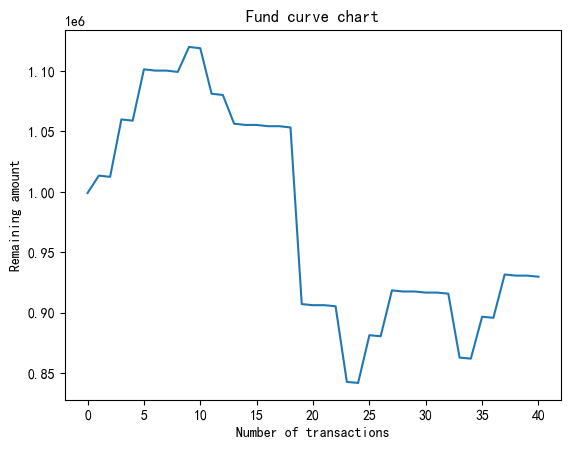

In [42]:
# 画出资金曲线图
plt.plot(money_list)
plt.xlabel("Number of transactions")
plt.ylabel("Remaining amount")
plt.title("Fund curve chart")
plt.show()

In [43]:
max_drawdown = (max(money_list) - min(money_list)) / max(money_list)
print(f"最大回撤:{max_drawdown*100}%")

最大回撤:24.854790075884363%
